# Introduction

This notebook provides a detailed overview of the analysis pipeline used to process and interpret partial pressure time series data generated by the miniRUEDI system. These analyses support the findings presented in the manuscript:

**Resilience of Deep Aquifer Microbial Communities to Seasonal Hydrological Fluctuations**  
*Sébastien Giroud¹, Longhui Deng, Mark A. Lever, Oliver S. Schilling, Rolf Kipfer*  
https://doi.org/10.1073/pnas.2422608122

---

## Background

The miniRUEDI (membrane inlet mass spectrometry) system was deployed at Lavey-les-Bains to monitor dissolved gas concentrations in deep groundwater at high temporal resolution. These time series provide insights into the dynamics of gas exchange, transport, and source mixing within the deep aquifer. By examining fluctuations in the partial pressures of key dissolved gases (e.g., CO₂, O₂, CH₄, He), we aim to detect seasonal patterns and evaluate their coupling with hydrological signals such as electrical conductivity (EC).

This high-frequency gas monitoring complements lower-resolution geochemical sampling and enables a more detailed understanding of transient processes in the subsurface.

---

## Purpose of This Notebook

This notebook documents the computational steps used to process, visualize, and interpret the miniRUEDI data. Specifically, it includes:

- **Import and preprocessing** of raw partial pressure time series,
- **Normalization and detrending** of gas signals,
- **Calculation of gas–gas and gas–EC correlations** over time,
- **Detection of seasonal cycles** in gas composition using harmonic regression and smoothing techniques,
- **Cross-correlation analysis** to evaluate lagged relationships between gas signals and EC,
- **Figure generation** for publication, including annotated seasonal plots and correlation matrices.

All file paths are defined through a centralized `config.py` file for modularity and reproducibility, and local-only files are excluded via `.gitignore`.

---

## Relation to Companion Notebook

This notebook complements a separate analysis notebook focused on **low-frequency geochemical datasets**, including stable water isotopes, methane isotope ratios, and noble gases. That notebook addresses seasonal mixing of groundwater sources and microbial community structure, while the current analysis emphasizes **dynamic gas behavior at high temporal resolution**.

---

> **Note:** The miniRUEDI data used in this notebook are included in the manuscript’s supplementary materials or are available upon request from the corresponding author.


# Environment loading

In [1]:
# === Environment Setup ===

# --- Core Scientific Libraries ---
import numpy as np                           # Numerical operations
import pandas as pd                          # Data manipulation
import matplotlib.pyplot as plt              # Plotting
import matplotlib.dates as mdates            # Time axis formatting
from matplotlib.ticker import MultipleLocator, FixedLocator
import seaborn as sns                        # Statistical visualizations

# --- OS and Environment Handling ---
import os
from dotenv import load_dotenv               # Load .env file variables
load_dotenv()                                # Activates .env support

# --- Machine Learning / Statistics ---
from scipy.optimize import curve_fit         # Curve fitting (e.g., sinusoidal)
from scipy.stats import rankdata             # Ranking for nonparametric tests
from sklearn.metrics import r2_score         # Regression model evaluation

# --- Notebook Display ---
from IPython.display import clear_output     # Console cleanup for long cells

# --- Custom Modules ---
from src.functions import *                  # User-defined utility functions
from src.config import DATA_DIR, FIGURES_DIR # Path handling from centralized config

# --- Reproducibility ---
import random
np.random.seed(42)
random.seed(42)

# --- Plot Style Settings ---
plt.rcParams.update({
    "figure.dpi": 150,                       # On-screen resolution
    "savefig.dpi": 300,                      # Output figure resolution
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": (8, 5)                 # Default figure size
})

# --- Inline plotting for Jupyter Notebook ---
%matplotlib inline

# --- Gas Types for Analysis ---
gases = ["CH4", "N2", "H2", "O2", "Ar", "CO2", "He", "Kr"]

# === Data Import (Initial Example) ===
# Example structure for normalized gas dataset loading
data_files = [DATA_DIR / 'P201.csv', DATA_DIR / 'P600.csv']
dfs_norm = {
    file.stem: process_dataframe(load_csv(file), gases=gases)
    for file in data_files
}

# Data Preparation

## Data Trimming

[P201] CO2 allowed range: 1.99 to 5.22
[P600] CO2 allowed range: 3.72 to 4.86
[P201] CH4 allowed range: 3.06 to 16.85
[P600] CH4 allowed range: 5.89 to 8.47


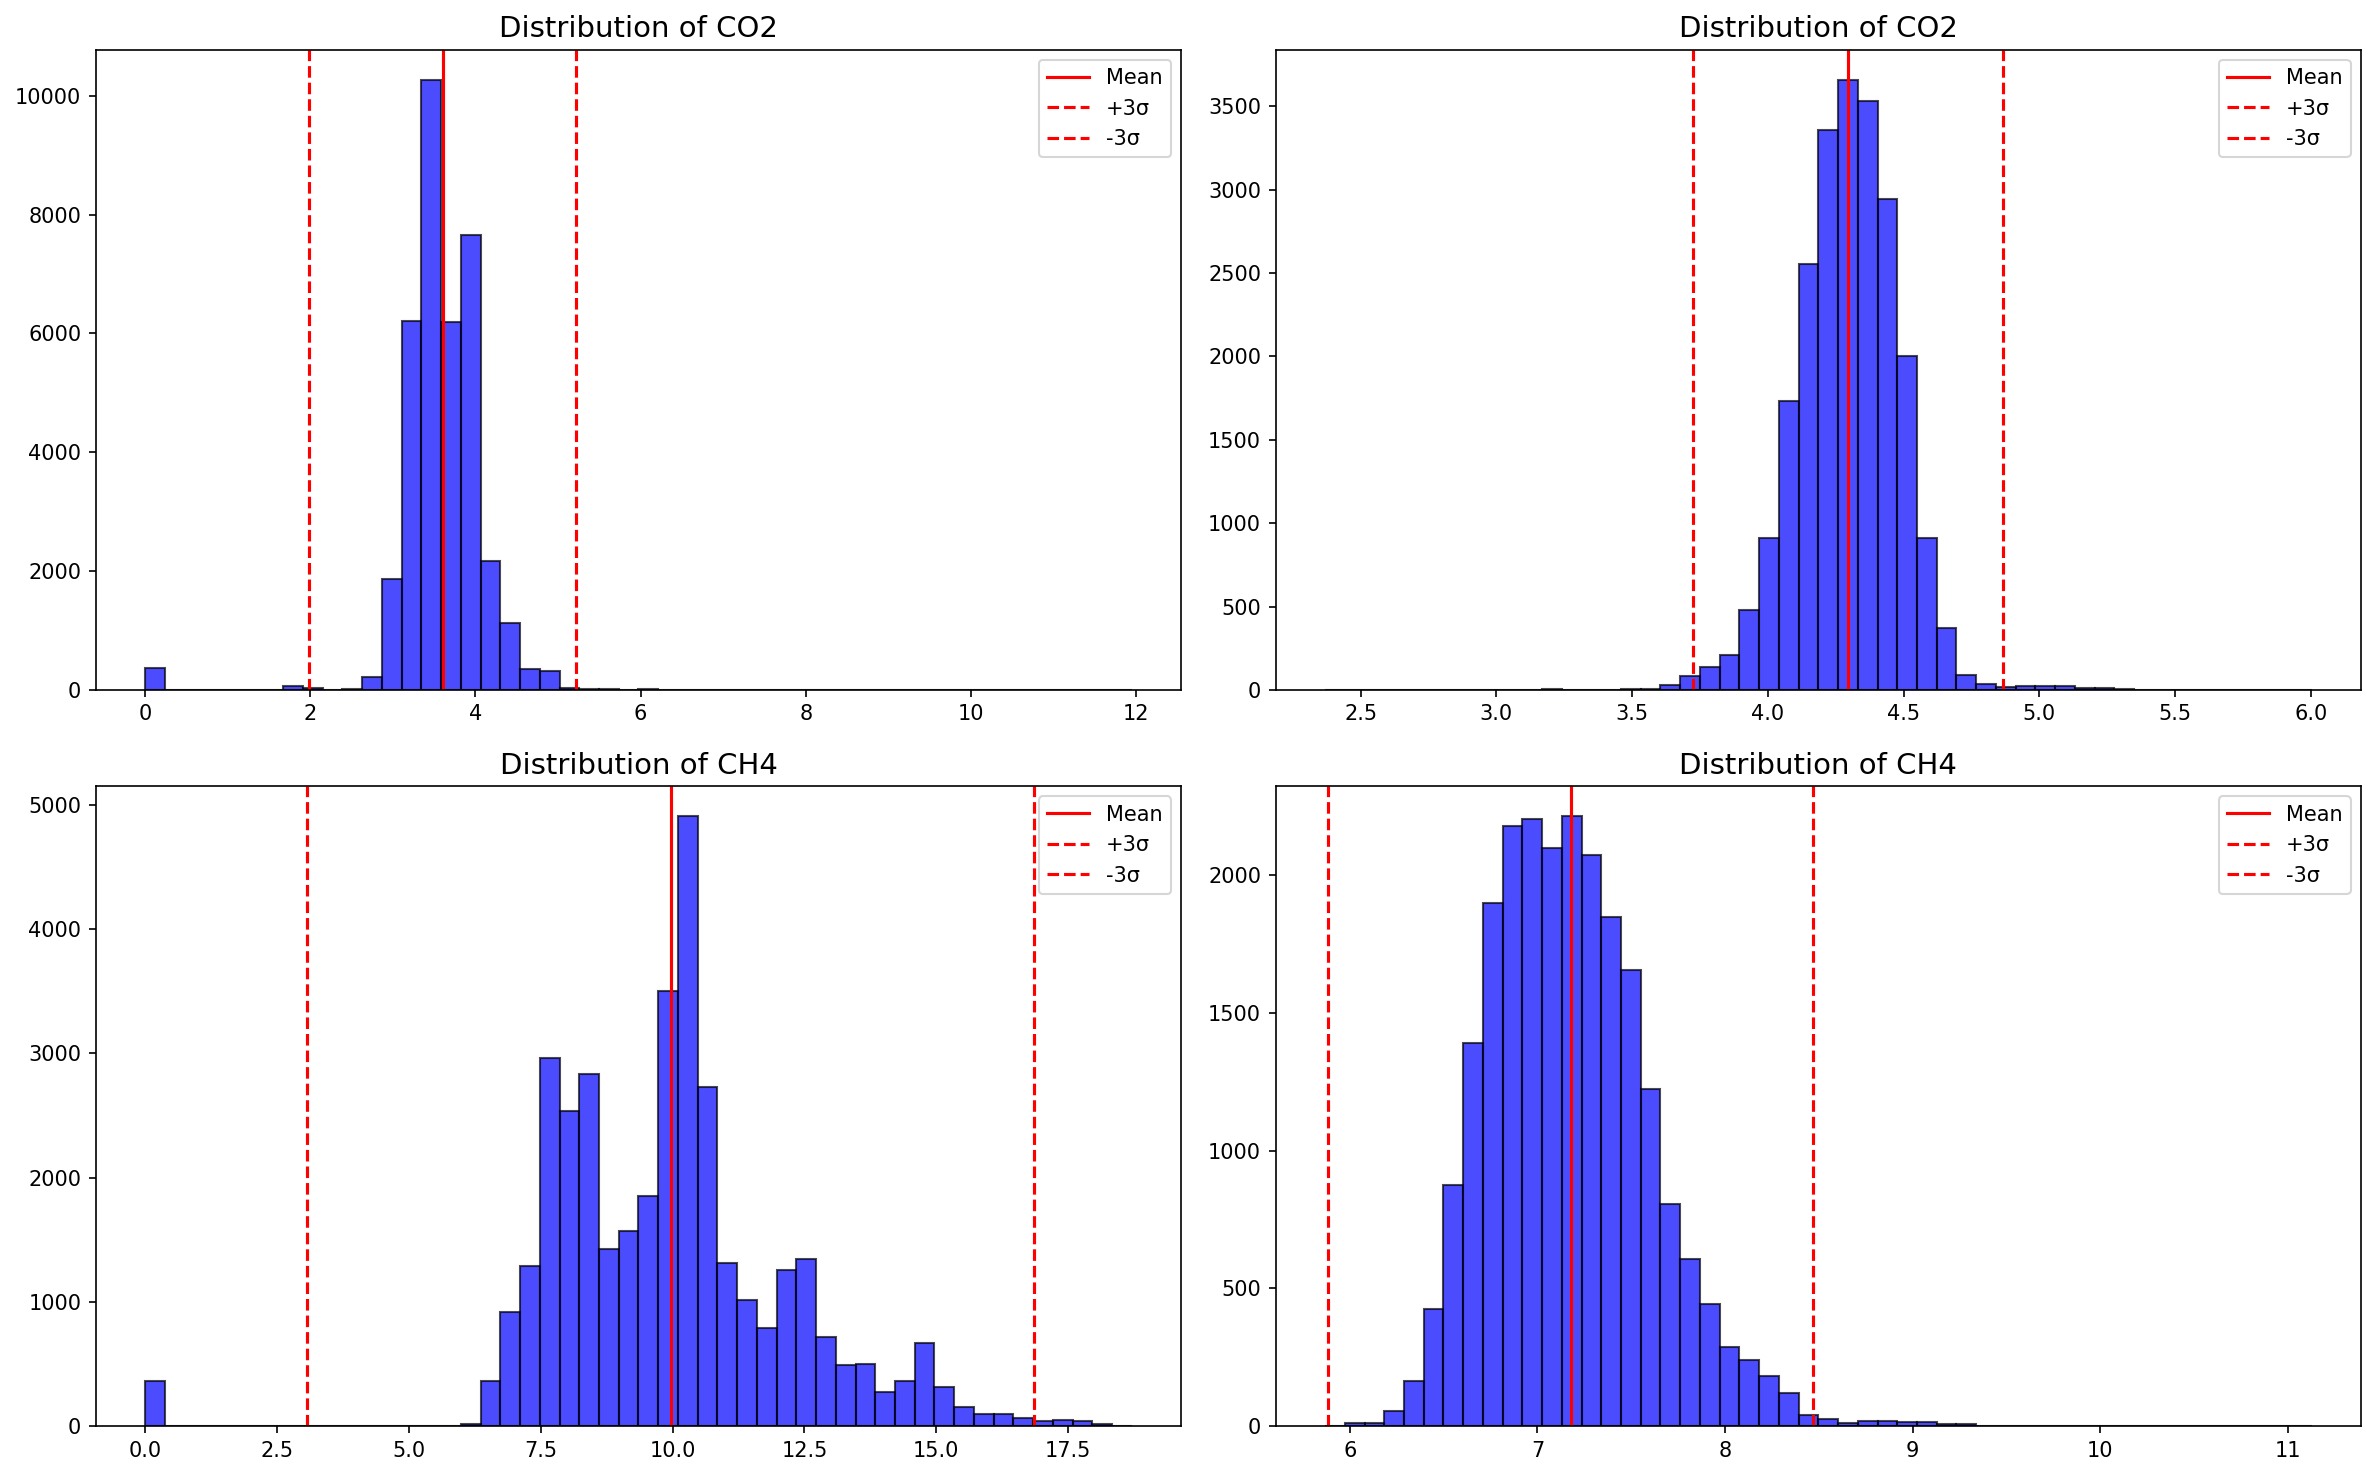

In [2]:
# ============================================
# 1. Initial Visualization of Distributions
# ============================================

# Set up 2×2 subplot grid for CH₄ and CO₂ in P201 and P600
fig, axes = setup_subplots()
plots = [
    ('P201', 'CO2', axes[0, 0]),
    ('P600', 'CO2', axes[0, 1]),
    ('P201', 'CH4', axes[1, 0]),
    ('P600', 'CH4', axes[1, 1]),
]

# Plot raw distributions with annotated limits
for well, gas, ax in plots:
    df = dfs_norm[well]
    mean, std, lower, upper = compute_limits(df, gas)
    plot_distribution(ax, df, gas, mean, std, lower, upper)
    print(f"[{well}] {gas} allowed range: {lower:.2f} to {upper:.2f}")

plt.tight_layout()

# ============================================
# 2. Outlier Removal (based on CO₂)
# ============================================
dfs_norm['P201'] = trim_outliers(dfs_norm['P201'], 'CO2', lower_limit=1.5, upper_limit=5.6)
dfs_norm['P600'] = trim_outliers(dfs_norm['P600'], 'CO2', lower_limit=1.5, upper_limit=5.6)

# ============================================
# 3. Remove Known Artefacts via Date Filtering
# ============================================

# Define known invalid or artefactual intervals
date_filters = {
    "P201": [
        ('2022-06-25', '2022-08-11'),
        ('2024-11-18', '2024-12-02'),
        # ('2024-09-01', '2025-04-01')  # Optional: leave commented for clarity
    ],
    "P600": [
        ('2023-11-01', '2023-11-07'),
        ('2023-12-01', '2023-12-31'),
        ('2024-07-01 12:00:00', '2024-08-01 12:00:00'),
        ('2024-02-01', '2024-02-13'),
    ]
}

# Apply date-based filters
for well, periods in date_filters.items():
    for start, end in periods:
        dfs_norm[well] = date_filter(dfs_norm[well], start, end)

# ============================================
# 4. Manual Value-Based Outlier Filtering
# ============================================

# Define custom filters: date + value threshold on CH₄
conditions = [
    {'well': 'P201', 'date_1': '2022-02-01', 'date_2': '2022-04-30', 'gas': 'CH4', 'value': 6.1, 'direction': '<'},
    {'well': 'P201', 'date_1': '2022-07-01', 'date_2': '2022-08-13', 'gas': 'CH4', 'value': 14,  'direction': '>'},
    
    {'well': 'P600', 'date_1': '2023-01-01', 'date_2': '2023-07-31', 'gas': 'CH4', 'value': 8.1, 'direction': '>'},
    {'well': 'P600', 'date_1': '2023-11-01', 'date_2': '2023-12-31', 'gas': 'CH4', 'value': 8.7, 'direction': '>'},
    {'well': 'P600', 'date_1': '2024-01-01', 'date_2': '2024-02-28', 'gas': 'CH4', 'value': 5.0, 'direction': '<'},
    {'well': 'P600', 'date_1': '2024-04-15', 'date_2': '2024-05-01', 'gas': 'CH4', 'value': 6.6, 'direction': '>'},
    {'well': 'P600', 'date_1': '2024-05-15', 'date_2': '2024-07-31', 'gas': 'CH4', 'value': 7.0, 'direction': '>'},
    {'well': 'P600', 'date_1': '2024-04-08', 'date_2': '2024-04-11', 'gas': 'CH4', 'value': 6.9, 'direction': '>'},
    {'well': 'P600', 'date_1': '2024-02-01', 'date_2': '2024-02-11', 'gas': 'CH4', 'value': 6.9, 'direction': '>'},
    {'well': 'P600', 'date_1': '2024-04-01', 'date_2': '2024-04-15', 'gas': 'CH4', 'value': 5.0, 'direction': '<'},
]

# Apply filters conditionally
for cond in conditions:
    remove_rows_by_condition(
        dfs_norm=dfs_norm,
        well=cond['well'],
        date_1=cond['date_1'],
        date_2=cond['date_2'],
        gas=cond['gas'],
        value=cond['value'],
        direction=cond['direction']
    )


## Resampling

In [3]:
# ============================================
# 5. Temporal Resampling of Filtered Data
# ============================================

# Apply custom resampling to normalize time resolution:
# - dfs_norm_h: hourly means
# - dfs_norm_d: daily means

dfs_norm_h, dfs_norm_d = resample_data_dict(dfs_norm)

print("Resampling complete:")
print(f"  ↳ Hourly datasets: {list(dfs_norm_h.keys())}")
print(f"  ↳ Daily datasets:  {list(dfs_norm_d.keys())}")

Resampling complete:
  ↳ Hourly datasets: ['P201', 'P600']
  ↳ Daily datasets:  ['P201', 'P600']


## Correlation

In [4]:
# ============================================
# 6. Gas-Gas Correlation Matrices (Hourly Data)
# ============================================

# Define gases of interest for correlation
gases_of_interest = ['CH4', 'N2', 'H2', 'O2', 'Ar', 'CO2', 'He', 'Kr']

# Compute correlation matrices for P201 and P600 (hourly-averaged)
correlation_matrix_h_P201 = dfs_norm_h['P201'][gases_of_interest].corr()
correlation_matrix_h_P600 = dfs_norm_h['P600'][gases_of_interest].corr()

# (Optional) Display correlation matrices
display(correlation_matrix_h_P201.style.background_gradient(cmap='coolwarm').set_caption("Hourly Gas Correlation - P201"))
display(correlation_matrix_h_P600.style.background_gradient(cmap='coolwarm').set_caption("Hourly Gas Correlation - P600"))

,CH4,N2,H2,O2,Ar,CO2,He,Kr
CH4,1.000000,0.799614,-0.448607,0.038481,0.798908,-0.515861,0.067807,0.432970
N2,0.799614,1.000000,-0.328761,0.109700,0.920907,-0.055907,-0.103179,0.669602
H2,-0.448607,-0.328761,1.000000,-0.241815,-0.232068,0.246925,0.402226,-0.060754
O2,0.038481,0.109700,-0.241815,1.000000,0.041513,0.012549,-0.150253,0.110835
Ar,0.798908,0.920907,-0.232068,0.041513,1.000000,-0.073501,0.084014,0.712940
CO2,-0.515861,-0.055907,0.246925,0.012549,-0.073501,1.000000,-0.328783,0.241287
He,0.067807,-0.103179,0.402226,-0.150253,0.084014,-0.328783,1.000000,-0.062700
Kr,0.432970,0.669602,-0.060754,0.110835,0.712940,0.241287,-0.062700,1.000000


,CH4,N2,H2,O2,Ar,CO2,He,Kr
CH4,1.000000,0.653439,0.142160,-0.325825,0.353753,0.707185,-0.039312,-0.042689
N2,0.653439,1.000000,0.032650,-0.104291,0.530904,0.562829,0.374056,0.233034
H2,0.142160,0.032650,1.000000,0.233627,-0.143582,0.291892,0.381305,0.431108
O2,-0.325825,-0.104291,0.233627,1.000000,0.274516,0.042715,0.575167,0.506296
Ar,0.353753,0.530904,-0.143582,0.274516,1.000000,0.410625,0.202699,0.033472
CO2,0.707185,0.562829,0.291892,0.042715,0.410625,1.000000,0.278421,0.240928
He,-0.039312,0.374056,0.381305,0.575167,0.202699,0.278421,1.000000,0.920234
Kr,-0.042689,0.233034,0.431108,0.506296,0.033472,0.240928,0.920234,1.000000


Correlation plot saved to:
/Users/sebastiengiroud/Documents/ETH/PhD/vscode/article2/figures/correlation_matrix_P201_P600.pdf


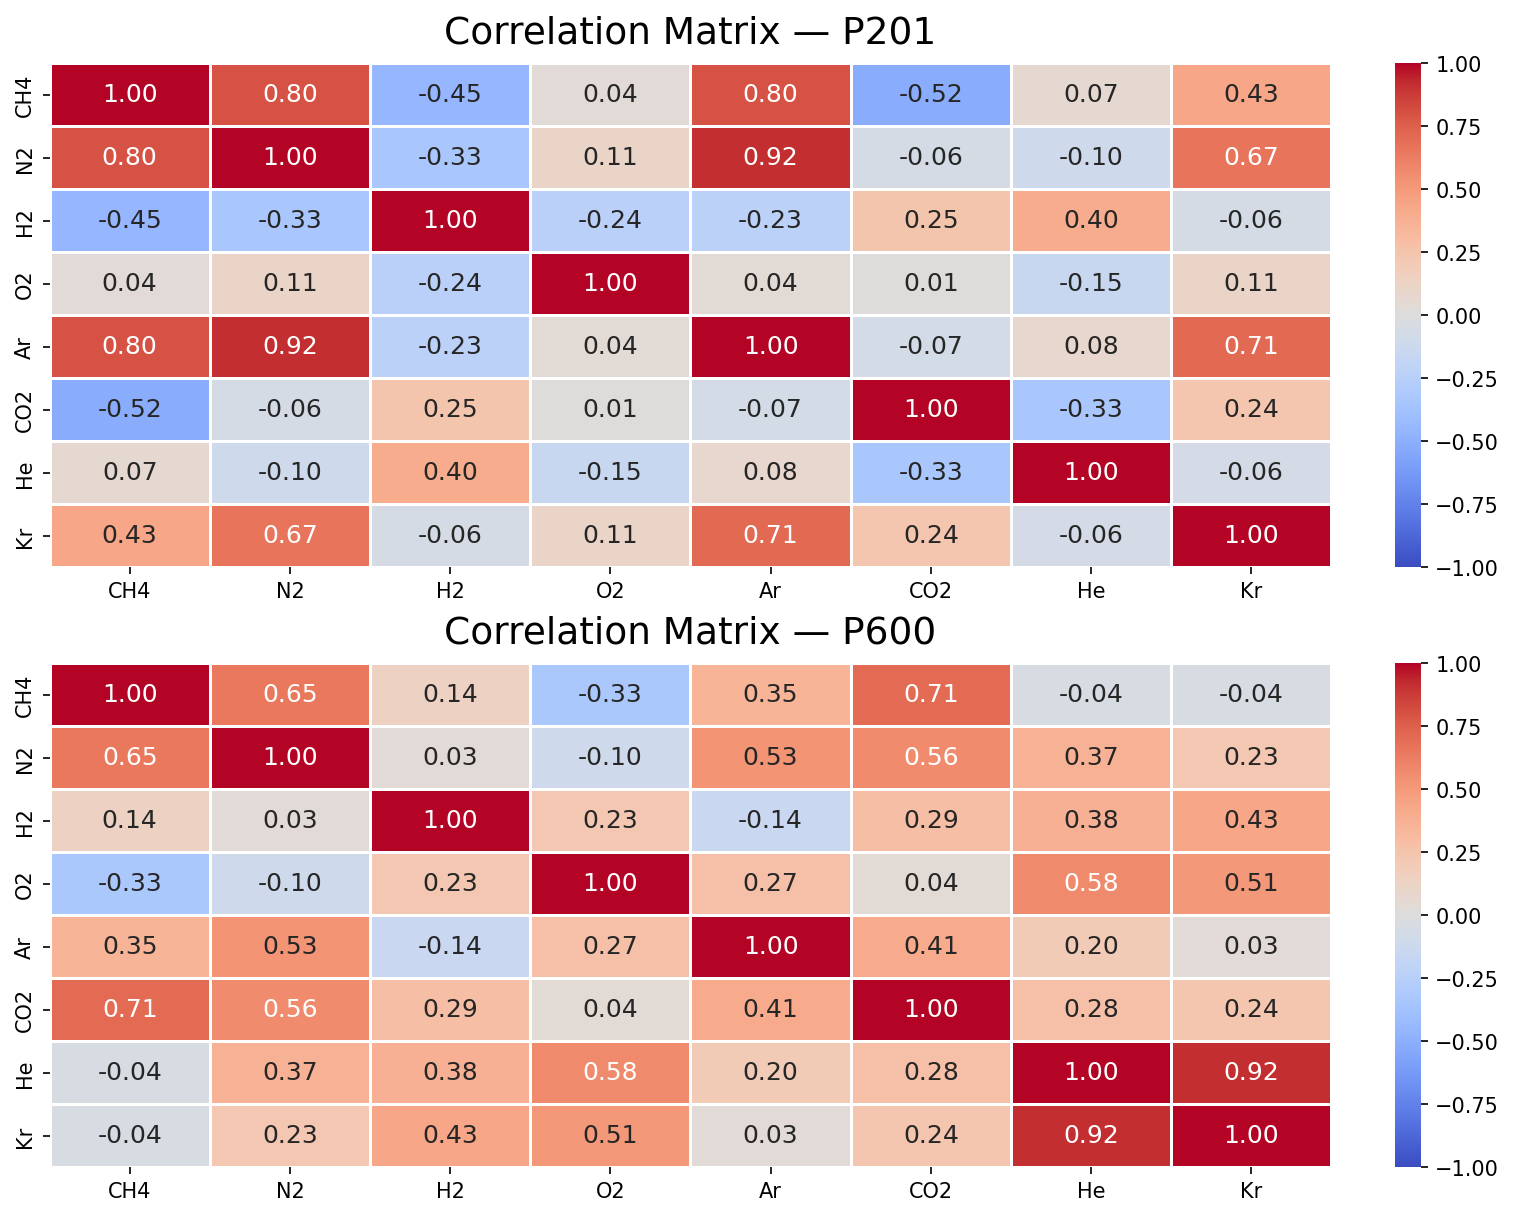

In [5]:
# ============================================
# 7. Plot Correlation Matrices for Publication
# ============================================

# Initialize figure and define layout
fig, axes = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True)

# Plot correlation matrix for P201
sns.heatmap(correlation_matrix_h_P201, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            fmt=".2f", linewidths=0.5, ax=axes[0])
axes[0].set_title('Correlation Matrix — P201', fontsize=18, pad=10)

# Plot correlation matrix for P600
sns.heatmap(correlation_matrix_h_P600, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            fmt=".2f", linewidths=0.5, ax=axes[1])
axes[1].set_title('Correlation Matrix — P600', fontsize=18, pad=10)

# Save high-resolution figure
output_path = os.path.join(FIGURES_DIR, "correlation_matrix_P201_P600.pdf")
plt.savefig(output_path, bbox_inches='tight')
print(f"Correlation plot saved to:\n{output_path}")

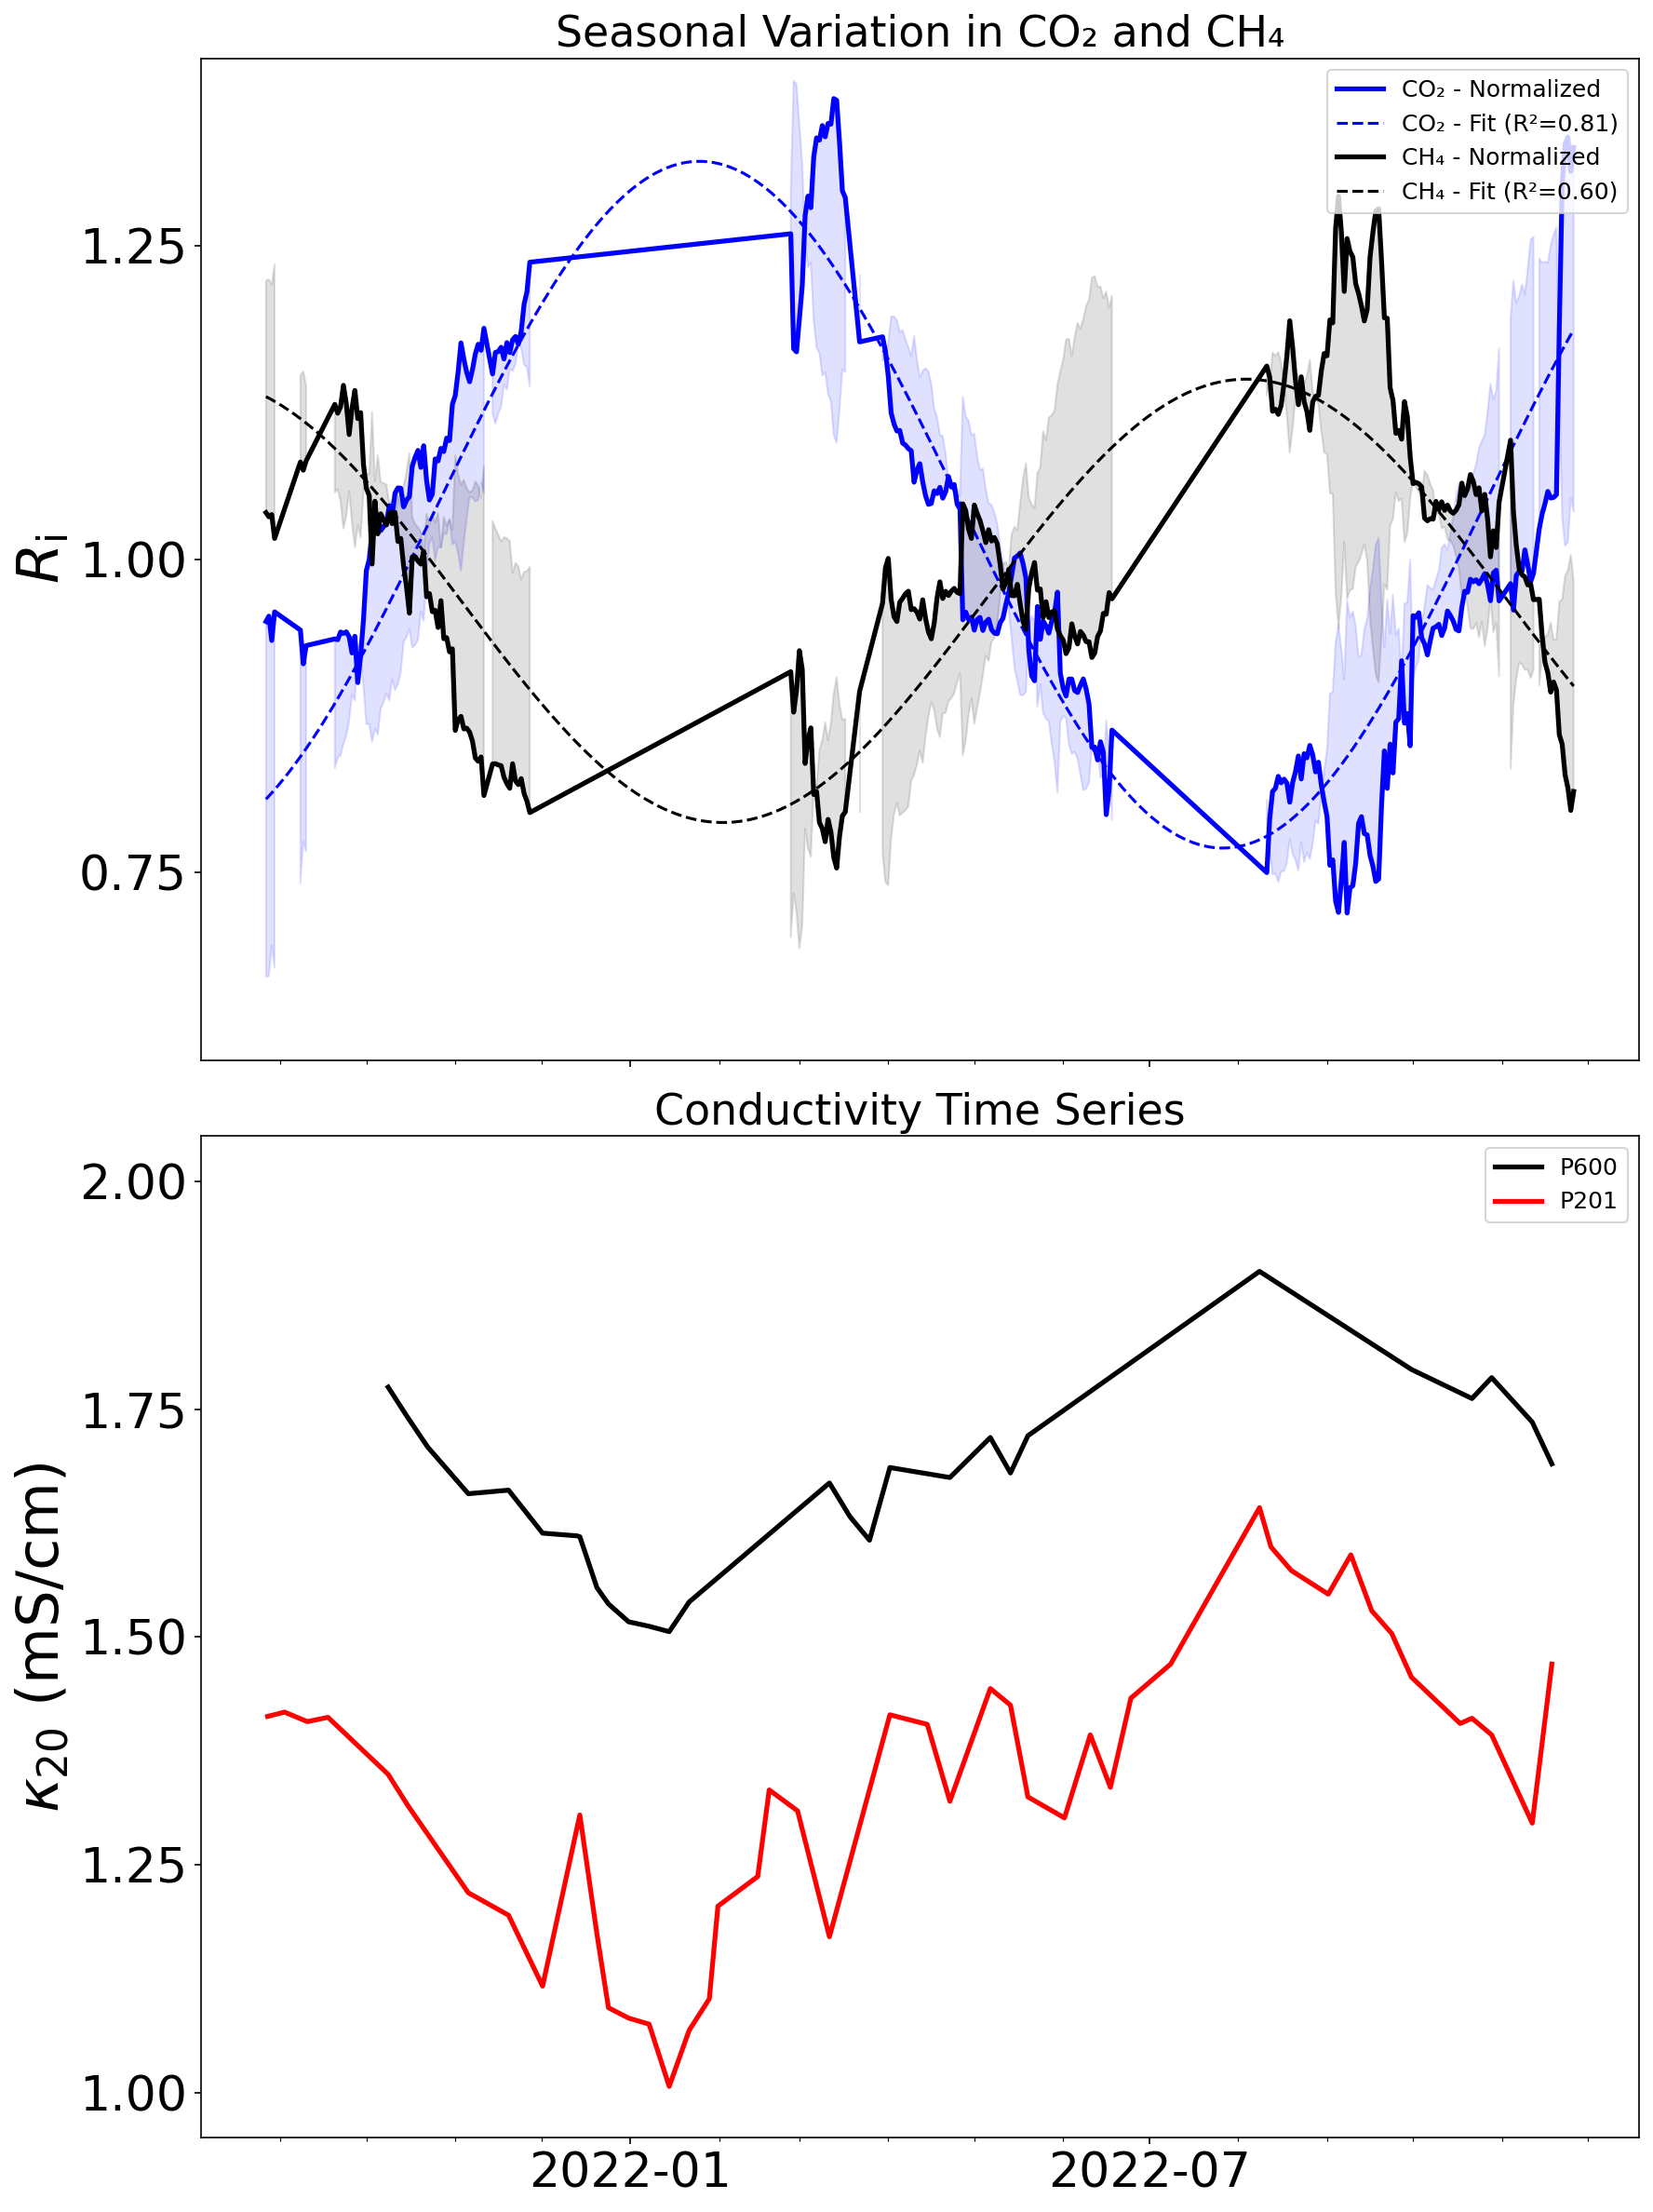

Figure saved to: /Users/sebastiengiroud/Documents/ETH/PhD/vscode/article2/figures/seasonality_gases_vs_conductivity.pdf


In [ ]:
# ============================================
# 8. Seasonal Gas Patterns vs Conductivity Plot
# ============================================

# --- Load and Prepare Conductivity Data --- (Conductivity data was provided by the thermal spa)
df_conductivity = pd.DataFrame({
    "Date": pd.to_datetime([
        "2021-08-27 13:25", "2021-09-02 11:45", "2021-09-10 10:00", "2021-09-17 14:45",
        "2021-10-08 14:30", "2021-10-15 10:45", "2021-10-22 10:10", "2021-11-05 13:25",
        "2021-11-19 14:00", "2021-12-01 10:45", "2021-12-13 08:10", "2021-12-14 10:30",
        "2021-12-20 10:00", "2021-12-24 10:00", "2021-12-31 10:45", "2022-01-07 14:00",
        "2022-01-14 14:40", "2022-01-21 13:50", "2022-01-28 14:20", "2022-01-31 14:25",
        "2022-02-14 11:35", "2022-02-18 11:30", "2022-02-28 09:00", "2022-03-11 11:38",
        "2022-03-18 14:40", "2022-03-25 10:58", "2022-04-01 13:30", "2022-04-14 14:30",
        "2022-04-22 11:40", "2022-05-06 13:55", "2022-05-13 14:30", "2022-05-19 16:30",
        "2022-06-01 10:40", "2022-06-10 10:40", "2022-06-17 11:00", "2022-06-24 14:15",
        "2022-07-08 11:20", "2022-08-08 11:00", "2022-08-12 11:00", "2022-08-19 13:30",
        "2022-09-01 10:20", "2022-09-09 07:30", "2022-09-16 14:00", "2022-09-23 13:35",
        "2022-09-30 10:30", "2022-10-17 10:45", "2022-10-21 13:00", "2022-10-28 09:50",
        "2022-11-11 13:30", "2022-11-18 09:30"
    ]),
    "P201": [
        1412.8011, 1417.5466, 1407.1065, 1411.852,
        1349.2114, 1315.0438, None, 1219.1847,
        1194.5081, 1116.6819, None, 1304.6037,
        1173.6279, 1092.9544, 1081.5652, 1074.9215,
        1006.5863, 1068.2168, 1102.7624, 1204.48,
        1237.1064, 1332.1068, 1309.0764, 1170.894,
        None, None, 1414.6324, 1404.0768,
        1319.632, 1443.4204, 1425.188, 1324.43,
        1301.3996, 1392.5616, 1334.9856, 1432.8648,
        1470.2892, 1642.0576, 1598.8756, 1572.9664,
        1547.0572, 1590.2392, 1528.8248, 1503.8752,
        1455.8952, 1405.0364, 1410.794, 1392.5616,
        1295.642, 1470.2892
    ],
    "P600": [
        None, None, None, None,
        1774.3547, 1740.9191, 1708.4669, 1657.3301,
        1661.2637, 1614.0605, 1611.1103, 1610.1269,
        1554.0731, 1536.3719, 1516.7039, 1511.7869,
        1505.8865, 1538.5136, None, None,
        None, None, None, 1669.1468,
        1632.2504, 1606.3232, 1686.0992, None,
        1675.13, 1719.0068, 1680.116, 1721.0012,
        None, None, None, None,
        None, 1901.4944, None, None,
        None, None, None, None,
        1793.7968, None, 1761.8864, 1784.822,
        1735.9592, 1690.088
    ]
}).set_index("Date")

# --- Filter Gas Data for Target Time Range ---
start_date, end_date = pd.to_datetime("2021-08-25"), pd.to_datetime("2022-11-30")
target_gases = ["CH4", "H2", "O2", "Ar", "CO2", "He", "Kr"]
P201_data = dfs_norm_d['P201'].loc[start_date:end_date]

# --- Normalize Gases by N2 and Their Own Mean ---
df_cleaned = P201_data[target_gases].dropna().div(P201_data["N2"].dropna(), axis=0)
df_normalized = df_cleaned / df_cleaned.mean()

# --- Time Axis Preparation for Fitting ---
x = mdates.date2num(df_normalized.index)
x_real = pd.date_range(df_normalized.index[0], df_normalized.index[-1])
initial_params = [1, 2*np.pi/365, np.deg2rad(170), 0]

# --- Fit Seasonal Curves ---
df_CO2_err, y_CO2_fit, y_CO2_plot, r2_CO2 = fitter(x, x_real, df_normalized["CO2"].to_numpy(), initial_params)
df_CH4_err, y_CH4_fit, y_CH4_plot, r2_CH4 = fitter(x, x_real, df_normalized["CH4"].to_numpy(), initial_params)

# === Plotting ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16), sharex=True)

# ---------------------
# Plot 1: Gas Seasonality
# ---------------------
ax1.plot(df_cleaned.index, df_normalized["CO2"], label="CO₂ - Normalized", color='blue', lw=2.5)
ax1.plot(x_real, y_CO2_plot, '--', color='blue', label=f"CO₂ - Fit (R²={r2_CO2:.2f})")
ax1.fill_between(df_CO2_err.index,
                 df_CO2_err["Fitted_Value"] + df_CO2_err["Predicted_Error"],
                 df_CO2_err["Fitted_Value"] - df_CO2_err["Predicted_Error"],
                 color='blue', alpha=0.12)

ax1.plot(df_cleaned.index, df_normalized["CH4"], label="CH₄ - Normalized", color='black', lw=2.5)
ax1.plot(x_real, y_CH4_plot, '--', color='black', label=f"CH₄ - Fit (R²={r2_CH4:.2f})")
ax1.fill_between(df_CH4_err.index,
                 df_CH4_err["Fitted_Value"] + df_CH4_err["Predicted_Error"],
                 df_CH4_err["Fitted_Value"] - df_CH4_err["Predicted_Error"],
                 color='black', alpha=0.12)

ax1.set_ylabel(r"$R_{\rm i}$", fontsize=30)
ax1.set_yticks(np.arange(0.5, 1.95, 0.25))
ax1.set_ylim(0.6, 1.4)
ax1.tick_params(labelsize=25)
ax1.legend(loc='upper right', fontsize=12)
ax1.set_title("Seasonal Variation in CO₂ and CH₄", fontsize=22)

# Format X-axis with monthly ticks
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
ax1.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# ---------------------
# Plot 2: Conductivity
# ---------------------
ax2.plot(df_conductivity["P600"].dropna().index, df_conductivity["P600"].dropna() / 1000,
         label='P600', color='black', lw=2.5)
ax2.plot(df_conductivity["P201"].dropna().index, df_conductivity["P201"].dropna() / 1000,
         label='P201', color='red', lw=2.5)

ax2.set_ylabel(r"$κ_{20}$ (mS/cm)", fontsize=30)
ax2.set_yticks(np.arange(0.5, 2.5, 0.25))
ax2.set_ylim(0.95, 2.05)
ax2.tick_params(labelsize=25)
ax2.legend(loc='upper right', fontsize=12)
ax2.set_title("Conductivity Time Series", fontsize=22)

# ---------------------
# Finalize and Save
# ---------------------
plt.tight_layout()
output_path = os.path.join(FIGURES_DIR, "seasonality_gases_vs_conductivity.pdf")
plt.savefig(output_path, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {output_path}")